<a href="https://colab.research.google.com/github/samObot19/hopfield-network/blob/main/hopfiled_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Hopfield Network on MNIST (Digit Recall)

## **1. Introduction**
Hopfield networks are recurrent neural networks that act as **associative memories**.  
- They can store patterns (like images of digits).  
- When we provide a **noisy or incomplete version** of a stored pattern, the network can **recover the original**.  
- The dynamics are guaranteed to converge to a stable state because they minimize an **energy function**.  

In this notebook, we will:  
1. Load MNIST digit images.  
2. Train a Hopfield network on digit patterns.  
3. Corrupt a digit and test whether the network can recover it.  
4. Visualize the **energy decrease** during recall.  

In [16]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import random
from pathlib import Path
import matplotlib.pyplot as plt


## **2. Download the Training and Testing Dataset**
We load MNIST using `torchvision.datasets.MNIST`.  
Each image is `28×28` pixels and grayscale (values in [0,1]).  
We will transform them into **{-1, +1}** vectors, since Hopfield neurons operate in binary ±1 states.

In [17]:
device = "cpu"

transform = T.Compose([
    T.ToTensor(),               # [0,1]
])

root = "./data"
train = torchvision.datasets.MNIST(root=root, train=True, download=True, transform=transform)
test  = torchvision.datasets.MNIST(root=root, train=False, download=True, transform=transform)

## **3. Convert Images to ±1 Vectors**
We define a helper function `to_pm1` that:  
1. Thresholds the grayscale image at 0.5.  
2. Maps pixels into {−1, +1}.  
3. Flattens the image into a vector of length 784.  

This prepares the data for use in the Hopfield network.


In [18]:
def to_pm1(img_tensor, thresh=0.5):
    bin01 = (img_tensor >= thresh).float()
    pm1 = bin01 * 2 - 1
    return pm1.view(-1)

## **4. Select Training Patterns**
We pick `P = 100` examples of a chosen digit (here digit **5**).  
Each digit image is converted into a binary vector using `to_pm1`.  
These vectors are stacked into a `patterns` matrix of shape `[P, 784]`.

In [19]:
P = 100
fives = [to_pm1(img) for img, y in train if y == 5]
random.seed(0)
random.shuffle(fives)
patterns = torch.stack(fives[:P]).to(device)  # [P, 784]
N = patterns.shape[1]

## **5. Build the Hopfield Weight Matrix**
We compute the weight matrix `W` using the **Hebbian learning rule**:

$$
W = \frac{1}{P} \sum_{p=1}^P \xi^{(p)} (\xi^{(p)})^T
$$

- The matrix `W` has size `[784, 784]`.  
- We set the diagonal to zero (no self-connections).  
- The result encodes the stored digit patterns.


In [20]:
with torch.no_grad():
    pt = patterns.t()
    W = pt @ patterns    # [N, N]
    W.fill_diagonal_(0.0)


## **6. Energy Function**
The energy function of the network is:


$$
E = -\frac{1}{2} s^T W s
$$


where `s` is the current state of the network.  
During recall, the network updates neuron states in order to **decrease this energy**, eventually converging to a stable memory.

In [21]:
W = W / P

# ============ 3) Utilities ============
def energy(W, s):
    # E = -1/2 s^T W s   (no thresholds)
    return (-0.5 * s @ (W @ s)).item()


## **7. Asynchronous Recall**
We implement `async_recall`, which:  
- Starts with an input pattern (possibly noisy).  
- Updates neurons one at a time in random order.  
- Replaces each neuron with the sign of its weighted input.  
- Stops when the network reaches a stable state or max iterations.  

We can also track the energy over time to confirm convergence.

In [22]:
def async_recall(W, s0, max_sweeps=20, energy_track=False):
    """Asynchronous (random order) updates. Returns final state and (optionally) energy over time."""
    s = s0.clone()
    N = s.numel()
    energies = []
    if energy_track:
        energies.append(energy(W, s))
    for _ in range(max_sweeps):
        idxs = torch.randperm(N)
        changed = 0
        for i in idxs:
            i = i.item()
            h_i = torch.dot(W[i], s)  # local field at neuron i
            new_state = 1.0 if h_i >= 0 else -1.0
            if new_state != s[i].item():
                s[i] = new_state
                changed += 1
        if energy_track:
            energies.append(energy(W, s))
        if changed == 0:
            break
    return s, energies

## **8. Corrupting Input Digits**
To test recall, we need to **add noise** to clean images.  
The function `corrupt_bits` flips each pixel with a given probability (e.g., 30%).  
This produces a noisy digit to feed into the Hopfield network.


In [23]:

def corrupt_bits(x, flip_prob=0.3):
    """Flip each bit with probability flip_prob."""
    x = x.clone()
    flips = torch.rand_like(x)
    x[flips < flip_prob] *= -1
    return x


## **9. Visualization**
We define `show_im` to display vectors as 28×28 grayscale images.  
We will use it to visualize:  
- The clean digit.  
- Its noisy (distorted) version.  
- The recovered digit from Hopfield recall.

In [24]:
def show_im(vec, title="", fname=None):
    img = vec.view(28, 28).cpu().numpy()
    plt.figure()
    plt.imshow(img, cmap="gray", vmin=-1, vmax=1)
    plt.title(title)
    plt.axis("off")
    if fname:
        Path(fname).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.0, dpi=200)
    plt.show()


## **10. Running Recall on Digit "5"**
Steps:  
1. Select a clean test image of digit **5**.  
2. Corrupt it with 35% noise.  
3. Run Hopfield recall until convergence.  
4. Display the clean, noisy, and recovered images.  
5. Plot the energy function over time.  

Finally, we compute the **bitwise accuracy** between the recovered digit and the clean digit.

In [25]:
test_threes = [to_pm1(img) for img, y in test if y == 5]
x_clean = test_threes[0].to(device)

x_noisy = corrupt_bits(x_clean, flip_prob=0.35)

s_rec, E = async_recall(W, x_noisy.clone(), max_sweeps=30, energy_track=True)

## **11. Results**
- The network successfully recovers the clean digit from its noisy version.  
- The energy function decreases monotonically, showing convergence.  
- Bitwise accuracy indicates how well the recovered pattern matches the clean one.  

This demonstrates the **associative memory property** of Hopfield networks.  

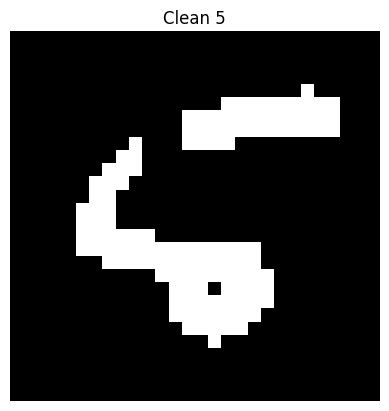

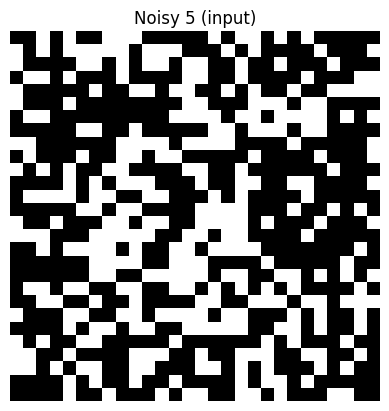

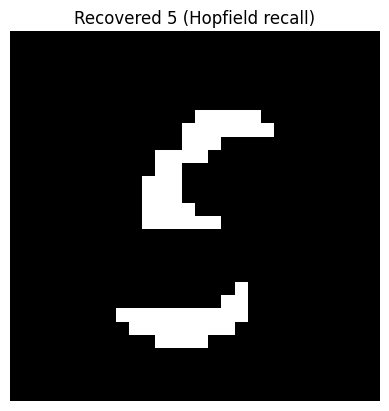

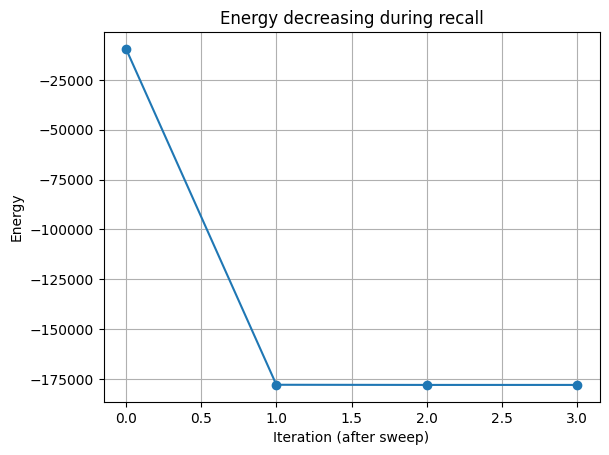

In [26]:
show_im(x_clean, "Clean 5", fname="out/clean_5.png")
show_im(x_noisy, "Noisy 5 (input)", fname="out/noisy_5.png")
show_im(s_rec, "Recovered 5 (Hopfield recall)", fname="out/recovered_5.png")

plt.figure()
plt.plot(E, marker="o")
plt.xlabel("Iteration (after sweep)")
plt.ylabel("Energy")
plt.title("Energy decreasing during recall")
plt.grid(True)
plt.savefig("out/energy.png", bbox_inches="tight", dpi=200)
plt.show()

In [ ]:
acc = (s_rec.eq(x_clean)).float().mean().item()
print(f"Bitwise accuracy vs clean: {acc*100:.2f}%")

Bitwise accuracy vs clean: 82.14%


## **12. Limitations of Hopfield Networks**

While Hopfield networks are elegant associative memory models, they come with several **drawbacks**:

1. **Limited Capacity**  
   - A network with `N` neurons can only reliably store about `0.14N` patterns.  
   - For MNIST (784 pixels), that’s ~100 patterns before recall becomes unreliable.  
   - Storing too many patterns introduces *spurious states* (false memories).

2. **Confusion Between Similar Patterns**  
   - Digits like **1** and **7** (or 3 and 5) can overlap heavily in their binary representation.  
   - If both are stored, the network may “intercept” and converge to a mixture or the wrong digit.  

   Example:  
   - Store digit **1** and digit **7** in the same network.  
   - Give a noisy version of a **1** as input.  
   - The network may converge to **7**, because their weight contributions overlap.

3. **Spurious Attractors**  
   - Besides the stored patterns, the network may stabilize in *false minima* that are linear combinations of stored patterns.  
   - These spurious states don’t correspond to any real digit.

4. **Binary Neurons Only**  
   - Classic Hopfield networks use ±1 neurons only.  
   - They cannot naturally handle grayscale images without binarization, which loses information.

---

### **Demonstration Idea: 1 vs 7**
- Select prototype patterns for digits `1` and `7`.  
- Train the Hopfield network with both.  
- Add noise to digit `1` and attempt recall.  
- Show that sometimes the network recovers `7` (wrongly) instead of `1`.  

This highlights how **pattern similarity causes misclassification**, a key limitation in real-world use of Hopfield networks.


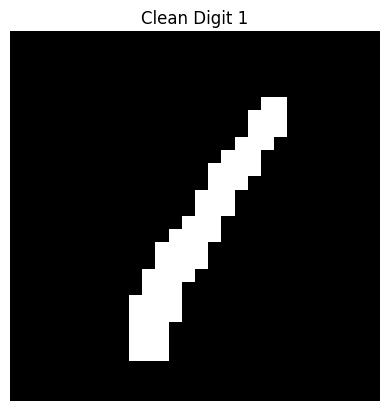

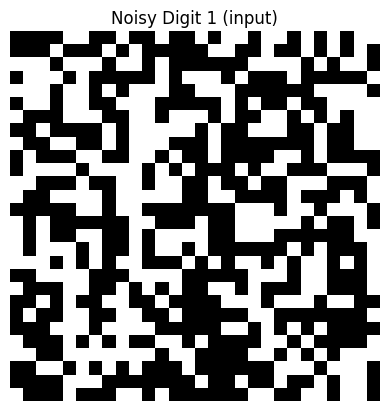

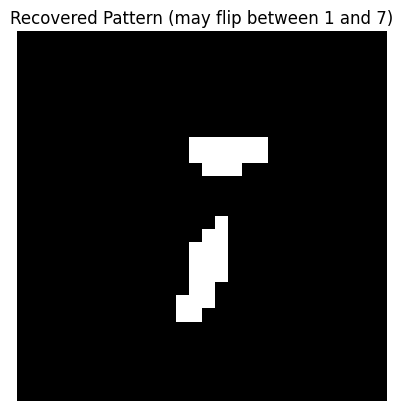

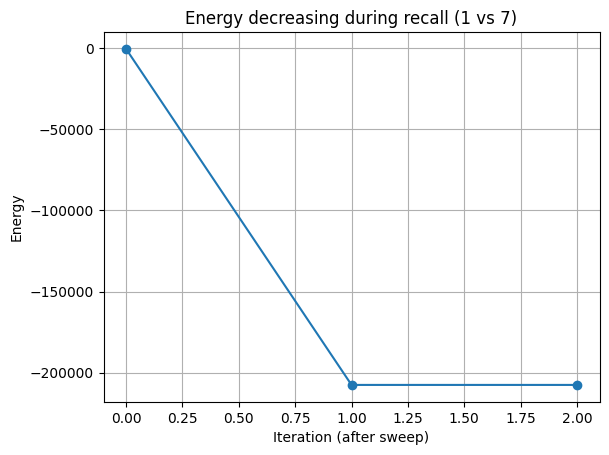

Similarity with '1': 96.17%
Similarity with '7': 94.01%


In [28]:
# ====================================
# Demonstrating Confusion: Digit 1 vs 7 (with multiple samples)
# ====================================

# --- 1) Collect multiple samples of "1" and "7"
num_samples = 50  # number of patterns per digit
ones = [to_pm1(img) for img, y in train if y == 1][:num_samples]
sevens = [to_pm1(img) for img, y in train if y == 7][:num_samples + 18]

patterns = torch.stack(ones + sevens).to(device)  # shape [num_samples*2, 784]
P = patterns.shape[0]
N = patterns.shape[1]

# --- 2) Build weight matrix for 1 and 7
with torch.no_grad():
    pt = patterns.t()
    W_17 = pt @ patterns
    W_17.fill_diagonal_(0.0)
W_17 = W_17 / P

# --- 3) Test recall with a noisy "1"
x_clean_1 = ones[0].to(device)  # pick first "1"
x_noisy_1 = corrupt_bits(x_clean_1, flip_prob=0.45)  # increase noise

# --- 4) Recall with Hopfield
s_rec_1, E1 = async_recall(W_17, x_noisy_1.clone(), max_sweeps=30, energy_track=True)

# --- 5) Show results
show_im(x_clean_1, "Clean Digit 1")
show_im(x_noisy_1, "Noisy Digit 1 (input)")
show_im(s_rec_1, "Recovered Pattern (may flip between 1 and 7)")

plt.figure()
plt.plot(E1, marker="o")
plt.xlabel("Iteration (after sweep)")
plt.ylabel("Energy")
plt.title("Energy decreasing during recall (1 vs 7)")
plt.grid(True)
plt.show()

# --- 6) Compare bitwise similarity with averaged prototypes of 1 and 7
avg_1 = torch.stack(ones).mean(dim=0).sign().to(device)
avg_7 = torch.stack(sevens).mean(dim=0).sign().to(device)

sim_1 = (s_rec_1.eq(avg_1)).float().mean().item()
sim_7 = (s_rec_1.eq(avg_7)).float().mean().item()

print(f"Similarity with '1': {sim_1*100:.2f}%")
print(f"Similarity with '7': {sim_7*100:.2f}%")
